## Libraries

In [1]:
import numpy as np
import pandas as pd

# We import the sk learn modules we'll need to segment our new data. We'll need scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# We import pickle in order to be able to load our pickled objects.
import pickle
# We import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 
#We import the necessary libraries for visualization. We set seaborn do be our default.
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
# We import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

## Data Preparation

In [2]:
#load data
df_purchase = pd.read_csv('purchase data.csv')

# Import Scaler
scaler = pickle.load(open('scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open('pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardization variables using standard scaler trained previously
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

# Apply PCA model which was trained previously
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Predicting Segment labels using k-means model trained previously
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()

# Add segment labels column
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca

# Create dummy variables for segment  
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')

# Concatenate dummy with orginal dataset
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

# Create new dataset 
df_pa = df_purchase_predictors

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


## Purchase Probability Model

In [3]:
# In order to predict we need input and output variables. 
# Our Y is Purchase Incidence, as we want to predict the purchase probability for our customers
Y = df_pa['Incidence']

In [4]:
pd.options.display.max_columns=None
df_pa.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0


In [5]:
# Our dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [6]:
# We create a Logistic Regression model using sk learn. Then we fit the model with our X or price and our Y or incidence.
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
# The coefficients for price. It is negative, signaling that with an increase in mean prices,
# the purchase probability decreases.
model_purchase.coef_

array([[-2.34725574]])

## Price Elasticity of Purchase Probability

In [8]:
# Here we see the prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [9]:
# We introduce the price range for which we'll examine the purchase probability.
# We choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8 to how elasticity change with change in price.
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [10]:
df_price_range = pd.DataFrame(price_range)

## Price elasticity by defination means % change in the purchase probability in response to the 1% change in the price.
# i.e Elasticity = delta (Purchase Prob)/ Purchase Prob :/: delta (Price) / Price

# The simplified formula for elasticity is 
# Elasticity = beta_coef * price * (1 - Purchase Prob)

In [11]:
# We predict the purchase probability for our newly defined price range. 
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]

# Calculate the price elasticity using the elasticity formula
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [12]:
# Create price elasticities master data frame.
# It will contain all the elasticities value that we calculate throughout.
df_price_elasticities = pd.DataFrame(price_range)

In [17]:
pd.options.display.max_rows = None
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096771
1,0.51,-0.100853
2,0.52,-0.105063
3,0.53,-0.109403
4,0.54,-0.113877
5,0.55,-0.118487
6,0.56,-0.123238
7,0.57,-0.128133
8,0.58,-0.133174
9,0.59,-0.138366


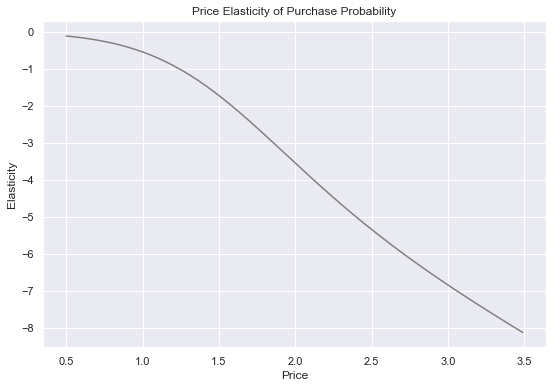

In [15]:
# We display the price elasticity of purchase probability of the average customer.
# We observe that the price elasticities are all negative. Furthermore we can spot where the customer becomes inelastic.
# But to find the precise spot we can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

From the elasticity graph, it can be observed that the elasticities are negative indicating that effect of price is inversely proportional to the elasticity. Also it can be seen that the rate of decrease is less steep between 0.5 to 1.1 and more steep afterwards. 
# By defination, if the elasticity value > 100% or |1| then it means its Elastic else Non- Elastic

By Figure, it can be seen that customer become elastic at approx 1.25 price point and from the dataset above, it can be seen that at 1.10 price (which was our min price), the elasiticity value is -0.69, meaning that with 1% increase in prices, the purchase probability decrease by 0.69% (which is less than 1% so it is inelastic at this price point). However, for the higher price point such as 1.50, the value is -1.70%, meaning that increase in price by 1% will now lead to decrease in purchase probability of 1.7% (which is greater than 1% so it is elastic at this price point)

The General recommendation is that we could increase the prices until 1.25 safely without much concerning about the purchase probability since it is inelastic till this price point. However, at higher than this price point, further increase in the price point will lead to significant decrease in purchase probability since it is inelastic at this price points. 

## Since the is the analysis of average customers, it gives us little insight about the different types of customer. To further refine our analysis, we need to perform the same analysis for each of the different segment of our customers to see that at which price point they become inelastic, to further augment our marketing strategy.

## Purchase Probability by Segments

### $\color{Blue}{\textbf{Segment 3 - Career-Focused}}$

In [20]:
df_segm_pca_kmeans_freq = df_pa.groupby(['Segment']).mean()
df_segm_pca_kmeans_freq

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
Segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.000002e+08,350.824750,0.200093,0.469923,0.553803,0.465736,0.198232,1.391593,1.778860,2.007155,2.159746,2.655301,0.347848,0.318679,0.045359,0.118027,0.035264,0.274064,0.098674,35.980554,0.766783,96654.659642,0.280391,0.049081,1,0,0,0
1,2.000003e+08,349.066980,0.211581,0.562897,0.662047,0.560175,0.210344,1.392221,1.782914,2.007025,2.159713,2.655297,0.342902,0.307432,0.043636,0.116225,0.038274,0.891034,0.913140,29.472408,1.053947,108731.349418,0.683164,0.412192,0,1,0,0
2,2.000003e+08,349.762070,0.294998,1.149630,0.898913,1.144585,0.293693,1.392999,1.781336,2.006464,2.160836,2.654993,0.340670,0.321792,0.042018,0.118921,0.036451,0.480296,0.671596,54.937016,2.106916,160577.416181,1.185994,1.102479,0,0,1,0
3,2.000002e+08,347.269956,0.322607,1.429676,0.762224,1.427835,0.322018,1.391922,1.782389,2.006273,2.159714,2.653390,0.341016,0.312813,0.038660,0.118115,0.034168,0.032032,0.159205,37.904050,0.823049,140623.871355,1.288513,1.455965,0,0,0,1


In [21]:
# From our segmentation model, it is clear that 0, 1, 2, 3 segments 
# corresponds to fewer-opportunity, Standard, Well-off, career-focussed
# mapping those labels to each segment.
df_pa['Segment Label'] = df_pa['Segment'].map({0: 'Fewer opportunity',
                                              1 : 'Standard',
                                              2 : 'Well-off',
                                              3 : 'Career-focussed'})
df_pa.head(10)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
5,200000001,23,0,0,0,0,0,1.50,1.90,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
7,200000001,37,0,0,0,2,1,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
8,200000001,41,0,0,0,0,0,1.35,1.58,1.97,2.09,2.67,1,1,1,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
9,200000001,43,0,0,0,0,0,1.35,1.58,1.97,2.09,2.67,1,1,1,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity


In [30]:
# We filter the data to contain only customers from segment 3, the career-focused.
# From our segment
df_pa_segment_3 = df_pa[df_pa['Segment Label'] == 'Career-focussed']
df_pa_segment_3.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
370,200000005,7,0,0,0,0,0,1.59,1.88,2.01,2.09,2.66,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
371,200000005,13,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
372,200000005,20,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
373,200000005,32,0,0,0,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
374,200000005,39,0,0,0,0,0,1.50,1.90,1.99,2.09,2.67,0,1,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed


In [31]:
# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_3['Incidence']

In [32]:
X = pd.DataFrame()

In [33]:
# We calculate the average price for purchases in segment 3. Our dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

In [35]:
# Fit logistic regression model
model_incidence_segment_3 = LogisticRegression(solver = 'sag')
model_incidence_segment_3.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
# We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segment_3.coef_

array([[-1.71094857]])

In [38]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_3 = model_incidence_segment_3.predict_proba(df_price_range)
purchase_pr_segment_3 = Y_segment_3[:, 1]
pe_segment_3 = model_incidence_segment_3.coef_[:, 0] * price_range * (1 - purchase_pr_segment_3)

### Results

In [40]:
df_price_elasticities['PE_Segment_CF'] = pe_segment_3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF
0,0.50,-0.096771,-0.118890
1,0.51,-0.100853,-0.123066
2,0.52,-0.105063,-0.127334
3,0.53,-0.109403,-0.131697
4,0.54,-0.113877,-0.136156
5,0.55,-0.118487,-0.140713
6,0.56,-0.123238,-0.145369
7,0.57,-0.128133,-0.150125
8,0.58,-0.133174,-0.154983
9,0.59,-0.138366,-0.159945


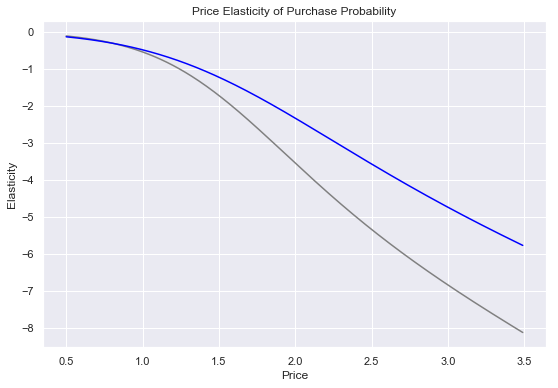

In [41]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. The same color we used during the descriptive analysis.
plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### From the graph, it is evident that career focussed segment is less price sensitive than the average customer and that it becomes inelastic at higher price point (1.39) as compared to (1.25) for average customers.

### $\color{red}{\textbf{Segment 0 - Fewer-Opportunities}}$

In [43]:
# Select only customers from segment 0, the fewer-opportunities.
df_pa_segment_0 = df_pa[df_pa['Segment Label'] == 'Fewer opportunity']

In [45]:
# Logistic regression model
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5

model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

# Calculate price elasticities
model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range * ( 1- purchase_pr_segment0)

### Results

In [48]:
df_price_elasticities['PE_Segment_Few'] = pe_segment0
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few
0,0.50,-0.096771,-0.118890,-0.031170
1,0.51,-0.100853,-0.123066,-0.032952
2,0.52,-0.105063,-0.127334,-0.034822
3,0.53,-0.109403,-0.131697,-0.036784
4,0.54,-0.113877,-0.136156,-0.038841
5,0.55,-0.118487,-0.140713,-0.040998
6,0.56,-0.123238,-0.145369,-0.043260
7,0.57,-0.128133,-0.150125,-0.045631
8,0.58,-0.133174,-0.154983,-0.048115
9,0.59,-0.138366,-0.159945,-0.050718


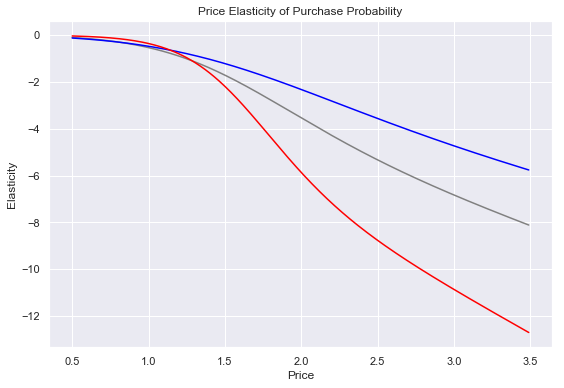

In [47]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. 
# The Few opportunity segment is displayed in red. 
plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Few'], color = 'red')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### It is evident that this segment is too much price sensitive and that it becomes inelastic at 1.27 which is little more than the overall customer's so we could hypothesize that due to this segment only the overall price point has been low.

### $\color{green}{\textbf{Segment 2 - Well-Off}}$

In [49]:
# Select only customers from segment 2, the Well-Off.
df_pa_segment_2 = df_pa[df_pa['Segment Label'] == 'Well-off']

In [51]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

### Results

In [52]:
df_price_elasticities['PE_Segment_Well'] = pe_segment2
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well
0,0.50,-0.096771,-0.118890,-0.031170,-0.168024
1,0.51,-0.100853,-0.123066,-0.032952,-0.172948
2,0.52,-0.105063,-0.127334,-0.034822,-0.177943
3,0.53,-0.109403,-0.131697,-0.036784,-0.183008
4,0.54,-0.113877,-0.136156,-0.038841,-0.188145
5,0.55,-0.118487,-0.140713,-0.040998,-0.193353
6,0.56,-0.123238,-0.145369,-0.043260,-0.198633
7,0.57,-0.128133,-0.150125,-0.045631,-0.203987
8,0.58,-0.133174,-0.154983,-0.048115,-0.209413
9,0.59,-0.138366,-0.159945,-0.050718,-0.214913


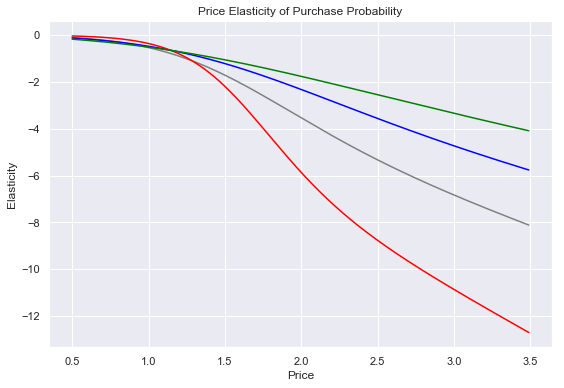

In [54]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. 
# The Few opportunity segment is displayed in red. 
# The Well Off segment is displayed in red. 

plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Few'], color = 'red')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Well'], color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### It is evident that Well off segment is highly insensitive to price change and that it becomes  in elastic at 1.46 which is the highest price point than other segments

### $\color{orange}{\textbf{Segment 1 - Standard}}$

In [55]:
# Select only customers from segment 1, the Standard.
df_pa_segment_1 = df_pa[df_pa['Segment Label'] == 'Standard']

In [56]:
# Logistic regression model
Y = df_pa_segment_1['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

model_incidence_segment1 = LogisticRegression(solver = 'sag')
model_incidence_segment1.fit(X, Y)

# Calculate price elasticities
model_incidence_segment1.coef_
Y_segment_1 = model_incidence_segment1.predict_proba(df_price_range)
purchase_pr_segment1 = Y_segment_1[: , 1]
pe_segment1 = model_incidence_segment1.coef_[:,0] * price_range * ( 1- purchase_pr_segment1)

### Results

In [57]:
df_price_elasticities['PE_Segment_Standard'] = pe_segment1
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard
0,0.50,-0.096771,-0.118890,-0.031170,-0.168024,-0.211146
1,0.51,-0.100853,-0.123066,-0.032952,-0.172948,-0.217715
2,0.52,-0.105063,-0.127334,-0.034822,-0.177943,-0.224392
3,0.53,-0.109403,-0.131697,-0.036784,-0.183008,-0.231177
4,0.54,-0.113877,-0.136156,-0.038841,-0.188145,-0.238072
5,0.55,-0.118487,-0.140713,-0.040998,-0.193353,-0.245076
6,0.56,-0.123238,-0.145369,-0.043260,-0.198633,-0.252191
7,0.57,-0.128133,-0.150125,-0.045631,-0.203987,-0.259418
8,0.58,-0.133174,-0.154983,-0.048115,-0.209413,-0.266757
9,0.59,-0.138366,-0.159945,-0.050718,-0.214913,-0.274209


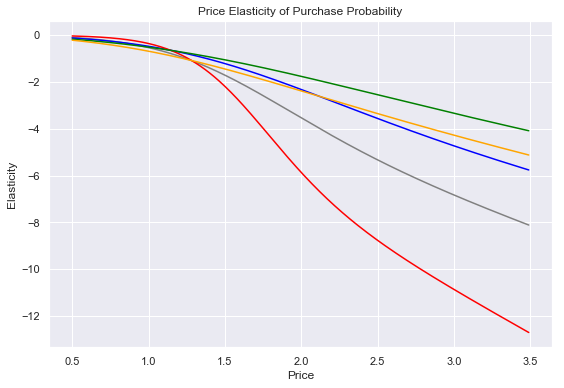

In [58]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. 
# The Few opportunity segment is displayed in red. 
# The Well Off segment is displayed in red. 
# The Standard segment is displayed in red. 


plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Few'], color = 'red')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Well'], color = 'green')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Standard'], color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### It is evident that Standard segment is between average and career focussed in response to price change and that it becomes  in elastic at 1.24 

# Purchase Probability with Promotion Feature

### Data Preparation

In [59]:
Y = df_pa['Incidence']

In [60]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [61]:
# We include a second promotion feature. We'd like to examine the effects of promotions on purchase probability.
# We then calculate the average promotion rate across the five brands. We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [62]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49400024,  0.56149271]])

## Price Elasticity with Promotion

In [63]:
# We create a data frame on which our model will predict. We need to include A price and promotion feature.
# First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [64]:
# We'll calculate price elasticities of purchase probability when we assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [65]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [66]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [67]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1
0,0.50,-0.096771,-0.118890,-0.031170,-0.168024,-0.211146,-0.125728
1,0.51,-0.100853,-0.123066,-0.032952,-0.172948,-0.217715,-0.129844
2,0.52,-0.105063,-0.127334,-0.034822,-0.177943,-0.224392,-0.134039
3,0.53,-0.109403,-0.131697,-0.036784,-0.183008,-0.231177,-0.138314
4,0.54,-0.113877,-0.136156,-0.038841,-0.188145,-0.238072,-0.142669
5,0.55,-0.118487,-0.140713,-0.040998,-0.193353,-0.245076,-0.147107
6,0.56,-0.123238,-0.145369,-0.043260,-0.198633,-0.252191,-0.151628
7,0.57,-0.128133,-0.150125,-0.045631,-0.203987,-0.259418,-0.156232
8,0.58,-0.133174,-0.154983,-0.048115,-0.209413,-0.266757,-0.160922
9,0.59,-0.138366,-0.159945,-0.050718,-0.214913,-0.274209,-0.165697


## Price Elasticity without Promotion

In [68]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [69]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [70]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [71]:
no_promo = Y_no_promo[: , 1]

In [72]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [73]:
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0
0,0.50,-0.096771,-0.118890,-0.031170,-0.168024,-0.211146,-0.125728,-0.195634
1,0.51,-0.100853,-0.123066,-0.032952,-0.172948,-0.217715,-0.129844,-0.201755
2,0.52,-0.105063,-0.127334,-0.034822,-0.177943,-0.224392,-0.134039,-0.207978
3,0.53,-0.109403,-0.131697,-0.036784,-0.183008,-0.231177,-0.138314,-0.214305
4,0.54,-0.113877,-0.136156,-0.038841,-0.188145,-0.238072,-0.142669,-0.220736
5,0.55,-0.118487,-0.140713,-0.040998,-0.193353,-0.245076,-0.147107,-0.227271
6,0.56,-0.123238,-0.145369,-0.043260,-0.198633,-0.252191,-0.151628,-0.233913
7,0.57,-0.128133,-0.150125,-0.045631,-0.203987,-0.259418,-0.156232,-0.240661
8,0.58,-0.133174,-0.154983,-0.048115,-0.209413,-0.266757,-0.160922,-0.247516
9,0.59,-0.138366,-0.159945,-0.050718,-0.214913,-0.274209,-0.165697,-0.254479


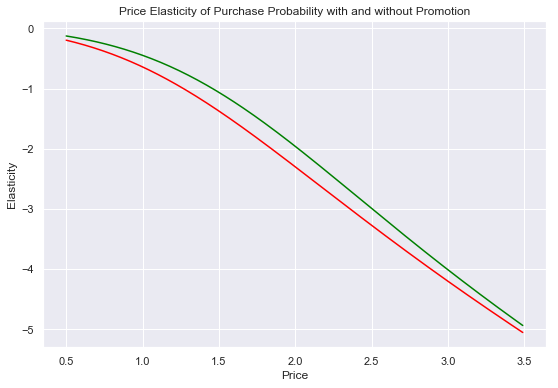

In [79]:
# Plot purchase elasticities with and without promotion side by side for comparison.
# With out promotion is red
# With promotion is green

plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo, color='red')
plt.plot(price_range, price_elasticity_promo, color='green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.show()

### Here we observe that the purchase probability elasticity of the customer is less elastic when there is promotion.This is an important insight for marketers, as according to our model people are more likely to buy a product if there is some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 
